## Using NLP to Analyse Data Science Articles in Medium to Uncover Topics and Predict Audience Engagement

##### By: David Bender for Springboard Course (May 2020 cohort) | email: [bender2242@gmail.com](mailto:bender2242@gmail.com)

###### This notebook is intended to help those who are interested in popular and emerging topics in data science, as well as provide some analysis that may be useful if you are thinking about writing your own data science blog posts or articles. Consider it a meta-analysis of data science topics and tactics, taken from authors who have published on the popular blogging site Medium. I will be using several approaches for natural language processing (NLP) including both supervised and unsupervised models to analyse the articles.


### STAGE 1: Import the dataset of Medium articles and explore the data

##### This data is available on Kaggle: [click here](https://www.kaggle.com/hsankesara/medium-articles)

>#### Step 1: Import the required packages and data
>#### Step 2: Clean it, edit values for errors and fix datatypes, and remove duplicates
>#### Step 3: Create a function to remove outliers
>#### Step 4: Create a function to preprocess the data for text analysis
>#### Step 5: Check the language of the text, keeping only English articles

---

## STAGE 2: Using NLP tools and approaches to analyse the text, including visualising the topics and phrases in the articles and predicting the number of claps that an article or title might receive from the Medium community.

#### Approach 1: scikit-learn prediction for number of claps, using the text of the articles

scikit-learn models:
- DummyRegressor (to baseline against random chance)
- CountVectorizer
- TfidfVectorizer

#### Approach 2: Analysing the text in context, including identifying entities mentioned in the articles and word analogies based on word vectors 

Models/Packages:
- spacy: Entity Recognition
- spaCy: word vector's (pre-trained on Wikipedia corpus)
- keras: word2vec

#### Approach 3: Analysing the topics in the articles using unsupervised topic modelling

Models/Packages:
- sklearn: Latent Dirichlet Allocation
- pyLDAvis: interactive topic visualisation and analysis tool

#### Approach 4: Predicting number of claps based on article text or title

Models/Packages:
- sklearn: RandomForestRegressor

In [106]:
## Import the required packages. Also available to install via the requirements.txt file in the project folder

# Standard python packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ML and NLP packages
import sklearn
import spacy
! python -m spacy download en_core_web_sm
import en_core_web_sm
import nltk

# Text processing
import re
import string
from bs4 import BeautifulSoup
from collections import Counter 
#nltk.download('words') # Use for English language corpus
#nltk.download('punkt') # Download for sentence and word tokenization

[+] Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


In [ ]:
import spacy

In [ ]:
nlp = spacy.load('en_core_web_sm')

In [1]:
! where python

C:\Users\David.Bender\Desktop\springboard\Capstone_2\capstone2\Scripts\python.exe
C:\Users\David.Bender\AppData\Local\Continuum\anaconda3\python.exe


In [ ]:
! C:\Users\David.Bender\Desktop\springboard\Capstone_2\capstone2\Scripts\python.exe -m spacy download en_core_web_sm

In [ ]:
import sys

sys.

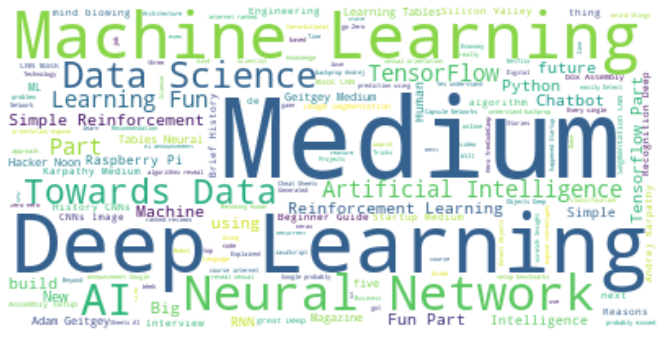

In [89]:
articles = pd.read_csv('data/articles.csv')

# Import the wordcloud library
from wordcloud import WordCloud
# Join the different processed titles together.
title_string = ','.join(list(articles.title.values))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=500, contour_width=3, contour_color='grey')
# Generate a word cloud
wordcloud.generate(title_string)
# Visualize the word cloud
plt.figure(figsize=(12,6))
plt.imshow(wordcloud, interpolation='bilinear')#.to_image()
plt.axis('off')
plt.show()

In [90]:
## For this dataset, we need to perform some basic data cleaning on some of the columns

# Format claps from string into integer
claps_number = []
for clap in articles.claps:
    if 'K' in str(clap):
        clap_num = clap[:-1]
        clap_num = float(clap_num) * 1000
        claps_number.append(int(clap_num))
    else:
        claps_number.append(clap)
        
articles['claps'] = [int(x) for x in claps_number] # Convert the claps column into the formatted number
filtered_columns = ['author','claps','title','text'] # Select columns in dataframe
articles = articles[filtered_columns]
articles = articles.drop_duplicates().reset_index(drop=True) # some duplicate articles were in the dataset
articles.head()

,author,claps,title,text
0,Justin Lee,8300,Chatbots were the next big thing: what happene...,"Oh, how the headlines blared:\nChatbots were T..."
1,Conor Dewey,1400,Python for Data Science: 8 Concepts You May Ha...,If you’ve ever found yourself looking up the s...
2,William Koehrsen,2800,Automated Feature Engineering in Python – Towa...,Machine learning is increasingly moving from h...
3,Gant Laborde,1300,Machine Learning: how to go from Zero to Hero ...,If your understanding of A.I. and Machine Lear...
4,Emmanuel Ameisen,935,Reinforcement Learning from scratch – Insight ...,Want to learn about applied Artificial Intelli...


#### Outlier values in the claps count will likely be an issue, so we will create a function to identify and visualise these examples

In [91]:
def exclude_outliers(data, sigma=2, negatives=False, rounded=0):
    '''Use this function to define the target variable counts that 
    you would like to exclude from your dataset. The default will exclude those
    indicate those row values that are greater than 2 standard deviations from the mean. Function returns 
    the cut-off values of selected sigma at upper and lower bounds and the
    n_top and n_bottom values to use to select a slice of your data.
    
    Variables:
        sigma - use to define the number of standard deviations from mean to return
        
        negatives - define whether the function should return negative lower bound values. Choose False for
                    one-tailed distributions.
        
        rounded - number of decimal places for the returned values'''
    
    mean = np.mean(data)
    std_dev = np.std(data)
    sigma_upper = mean + sigma * std_dev
    sigma_lower = mean - sigma * std_dev
    if negatives == True:
        sigma_lower = sigma_lower
    else:
        if sigma_lower < 0:
            sigma_lower = 0
    
    n_top = len(data[data > sigma_upper])
    n_bottom= len(data[data < sigma_lower])
    
    return round(sigma_upper, rounded), round(sigma_lower,rounded), n_top, n_bottom

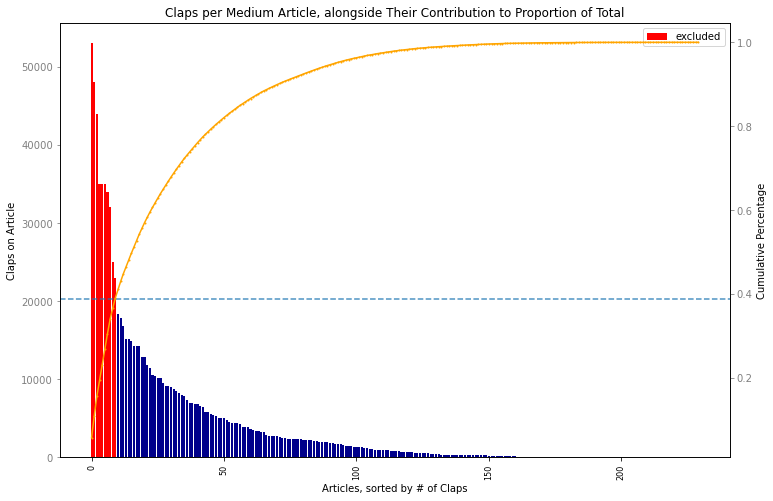

The articles to exclude from our model are:

1 - How Does Spotify Know You So Well? – Member Feature Stories – Medium: 53000 claps.
2 - I interviewed at five top companies in Silicon Valley in five days, and luckily got five job offers: 48000 claps.
3 - Blockchain is not only crappy technology but a bad vision for the future: 44000 claps.
4 - The impossibility of intelligence explosion – François Chollet – Medium: 35000 claps.
5 - Software 2.0 – Andrej Karpathy – Medium: 35000 claps.
6 - Machine Learning is Fun! – Adam Geitgey – Medium: 35000 claps.
7 - Artificial Intelligence — The Revolution Hasn’t Happened Yet: 34000 claps.
8 - A Beginner’s Guide to AI/ML 🤖👶 – Machine Learning for Humans – Medium: 32000 claps.
9 - Artwork Personalization at Netflix – Netflix TechBlog – Medium: 25000 claps.
10 - Understanding Hinton’s Capsule Networks. Part I: Intuition.: 23000 claps.


In [92]:
## We will apply the function above to our clap count column
outliers = exclude_outliers(articles.claps, negatives=False, rounded=0)

upper_claps = outliers[0]
lower_claps = outliers[1]
n_upper = outliers[2]
n_lower = outliers[3]

## Then plot the results in a Paretto chart, which indicates both the count and the cumulative percentage
sorted_table = articles.sort_values('claps', ascending=False).drop_duplicates().reset_index(drop=True) # There are some duplicates
sorted_table['cumulative'] = sorted_table['claps'].cumsum()/sorted_table['claps'].sum()*100

# Establish variables that will create the graph
color_included = 'darkblue'
color_excluded = 'red'
n_top_selection = n_upper
clap_cutoff = upper_claps
bar_color = [color_included if x < clap_cutoff else color_excluded for x in sorted_table.claps]
bar_labels = ['included' if x < clap_cutoff else 'excluded' for x in sorted_table.claps]

## Then plot the results to see what the ideal cut-off should be, indicated by a horizontal line
fig, ax = plt.subplots(figsize=(12,8))
ax.bar(sorted_table.index, sorted_table['claps'], color=bar_color, linewidth=0)
ax.legend(labels=bar_labels)
plt.xticks(rotation=90, fontsize=8)
ax2 = ax.twinx()
ax2.plot(sorted_table.index, [(x/100) for x in sorted_table['cumulative']], color="orange", marker="o", ms=1)
ax.set_xlabel('Articles, sorted by # of Claps')
ax.set_ylabel('Claps on Article')
ax2.set_ylabel('Cumulative Percentage')

ax.tick_params(axis="y", colors="grey")
ax2.tick_params(axis="y", colors="grey")
plt.title('Claps per Medium Article, alongside Their Contribution to Proportion of Total')
ax.axhline(y=clap_cutoff, ls='--', alpha=0.8)
plt.show()

print('The articles to exclude from our model are:\n')
for x in range(len(sorted_table[:10])):
    print('{} - {}: {} claps.'.format(x+1,sorted_table.iloc[x]['title'],sorted_table.iloc[x]['claps']))

In [93]:
## Now we can filter the articles dataset by removing the outliers

articles = articles[(articles.claps < upper_claps) & (articles.claps > lower_claps)].reset_index(drop=True)
print('The dataset has {} articles at this stage, after removing duplicates.'.format(len(articles)))

The dataset has 220 articles at this stage, after removing duplicates.


#### Next, we will preprocess the text for analysis

##### We can do this by creating a function that will allow us to specify which preprocessing steps we would like to perform

In [94]:
## Preprocess text for analysis

def remove_punct(text):
    text = re.sub(r'[^\w\s]','',text)
    return text
    
def remove_unprintable_characters(text):
    # Will eliminate non-English text characters
    printable = set(string.printable)
    text = "".join(filter(lambda x: x in printable, text))
    return text

def remove_special_characters(text, remove_digits=False):
    pattern = r'[^a-zA-z0-9\s]' if not remove_digits else r'[^a-zA-z\s]'
    text = re.sub(pattern, '', text)
    return text

def lower_all_text(text):
    text = text.lower()
    return text

def remove_stop_words(text):
    stop_words = set(nltk.corpus.stopwords.words('english'))
    text = [ w for w in nltk.wordpunct_tokenize(text) if not w in stop_words ]
    text = str(" ".join(w for w in text))
    return text

def lemmatize_text(text):
    nlp = spacy.load('en')
    text = nlp(text)
    text = ' '.join([word.lemma_ if word.lemma_ != '-PRON-' else word.text for word in text])
    return text

## Combine these functions all together into one single preprocessing function
def preprocess_text(text, 
                    remove_punctuation=True, 
                    printable_only=True,
                    remove_special=True,
                    lower_all=True, 
                    stop_words=True,
                    lemmatize=True,
                    no_digits=False):
    '''Other options for preprocessing: Remove hyperlinks, or remove breaks'''
    if remove_punctuation:
        text = remove_punct(text)
    if printable_only==True:
        text = remove_unprintable_characters(text)
    if remove_special:
        text = remove_special_characters(text, remove_digits=no_digits)
    if lower_all==True:
        text = lower_all_text(text)
    if stop_words==True:
        text = remove_stop_words(text)
    if lemmatize:
        text = lemmatize_text(text)
    return text

<b>NOTE:</b> Originally, I had created a function to eliminate English words using NLTK's words corpus. However, I noticed that it was removing a lot of proper nouns and terms that would be highly relevant to data science topics. So, instead, I applied two different approaches below (one from scratch and the other using the lang-detect package) to identify English articles - but kept all of the words in the preprocessed text for the future analysis. This is a good example of understanding the order of operations for text pre-processing.

In [95]:
## Apply this custom function to the text of the articles in our dataset

if 1==1: # Change this to a TRUE statement to run the above function in a customised way on the articles
    articles['preprocessed_text'] = [ preprocess_text(article, lemmatize=False) for article in articles.text ]
    articles.to_csv('data/preprocessed_articles.csv')

else:   # Or, you can just retrieve the dataset preprocessed with all the parameters initialised
    articles = pd.read_csv('data/preprocessed_articles.csv').iloc[:,1:]

In [96]:
## Now let's look at the dataset after these modifications (or to retrieve the DataFrame)
articles.head()

,author,claps,title,text,preprocessed_text
0,Justin Lee,8300,Chatbots were the next big thing: what happene...,"Oh, how the headlines blared:\nChatbots were T...",oh headlines blared chatbots next big thing ho...
1,Conor Dewey,1400,Python for Data Science: 8 Concepts You May Ha...,If you’ve ever found yourself looking up the s...,youve ever found looking question concept synt...
2,William Koehrsen,2800,Automated Feature Engineering in Python – Towa...,Machine learning is increasingly moving from h...,machine learning increasingly moving handdesig...
3,Gant Laborde,1300,Machine Learning: how to go from Zero to Hero ...,If your understanding of A.I. and Machine Lear...,understanding ai machine learning big question...
4,Emmanuel Ameisen,935,Reinforcement Learning from scratch – Insight ...,Want to learn about applied Artificial Intelli...,want learn applied artificial intelligence lea...


##### A faster way to do the step below and identify the language of text is to use the langdetect python package, available [HERE](https://pypi.org/project/langdetect/), with an example a few cells down.

In [97]:
## To filter our dataset to articles in English, we will identify those articles with predominantly English words.
## We will do this using nltk's corpus of Enlgish words.

def english_only(text):
    english_corpus = set(nltk.corpus.words.words())
    text = [ w for w in nltk.wordpunct_tokenize(text) if w in english_corpus ]
    return text

def english_filter(text):
    word_count = len(nltk.wordpunct_tokenize(text))
    english_word_count = len(english_only(text))
    ratio = round(english_word_count / word_count,2)
    return ratio

In [98]:
# Using an imported package, that is specifically for this purpose
from langdetect import detect

articles['langdetect'] = [detect(text) for text in articles.text]

In [99]:
## Now let's take a look at the code

if 0 == 1:
    # Set the above formula to TRUE to run the function for yourself
    ## Then we can check articles by their 'English ratio' to sense check the results, this may depend on the dataset
    threshold = 0.40

## After some simple examination of the Medium articles it looks like a good threshold is 40%.
## This will account for all of the proper nouns, typos, and uncommon words used in the field of data science.
    articles['is_english'] = articles.english_article > threshold
    articles[articles.is_english == False]
    articles['english_article'] = [ english_filter(article) for article in articles.text ]

else:
    articles = articles[articles['langdetect'] == 'en']
    
articles.to_csv('data/preprocessed_articles_english_only.csv')

## STAGE 2:

#### Approach 1: scikit-learn prediction for number of claps, using the text of the articles

Models:
- DummyRegressor (to baseline against random chance)
- CountVectorizer
- TfidfVectorizer

#### Approach 2: Analysing the text in context, including identifying entities mentioned in the articles and word analogies based on word vectors 

Models/Packages:
- spacy: Entity Recognition
- spaCy: word vector's (pre-trained on Wikipedia corpus)
- keras: word2vec

#### Approach 3: Analysing the topics in the articles using unsupervised topic modelling

Models/Packages:
- sklearn: Latent Dirichlet Allocation
- pyLDAvis: interactive topic visualisation and analysis tool

#### Approach 4: Predicting number of claps based on article text or title

Models/Packages:
- sklearn: RandomForestRegressor

In [ ]:
## First, let's import the packages we will be using and initialise the training and test data

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

X = articles.preprocessed_text
y = articles.claps

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=47)

In [ ]:
## How does this prediction do against random chance?
## To analyse this, we use sklearn's DummyRegressor on the data
from sklearn.dummy import DummyRegressor

dummy_clf = DummyRegressor()
dummy_clf.fit(X_train, y_train)
dummy_pred = dummy_clf.predict(X_test)

# Evaluate the squared MSE
np.sqrt(mean_squared_error(y_test, dummy_pred))

In [ ]:
## CountVectorizer using RandomForestRegressor

from sklearn.feature_extraction.text import CountVectorizer

vect = CountVectorizer(stop_words='english')

count_train = vect.fit_transform(X_train)

# We can also create a dataframe to visualise the array of words (or tokens) in the text
X_train_ctm = pd.DataFrame(count_train.toarray(),columns=vect.get_feature_names())

# Prepare testing data
count_test = vect.transform(X_test)

# Instantiate the model
count_RFR = RandomForestRegressor()

# Fit the model using the training array and training labels
count_RFR.fit(count_train, y_train)

# Run model on the testing data
count_y_pred = count_RFR.predict(count_test)

# Evaluate using squared mean squared error
print('The MSE of this model is: {:,.3f}'.format(np.sqrt(mean_squared_error(y_test, count_y_pred))))

In [ ]:
## TfidfVectorizer, also using RandomForestRegressor

from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(stop_words='english')

tfidf_train = tfidf.fit_transform(X_train)
tfidf_test = tfidf.transform(X_test)

# Now, we instantiate the model
tfidf_RFR = RandomForestRegressor()

# Fit the model using the training array and training labels
tfidf_RFR.fit(tfidf_train, y_train)

# Run model on the testing data for prediction
tfidf_y_pred = tfidf_RFR.predict(tfidf_test)

# Evaluate using squared mean squared error
print('The MSE of this model is: {:,.3f}'.format(np.sqrt(mean_squared_error(y_test, tfidf_y_pred))))

In [ ]:
from nltk import bigrams, trigrams

#### Approach 2: word2vec

In [ ]:
# 1: Use a pre-trained model on Wikipedia from spaCy
# Load the spacy model that you have installed
nlp = spacy.load('en_core_web_md')
# process a sentence using the model
doc = nlp("This is some text that I am processing with Spacy")
# It's that simple - all of the vectors and words are assigned after this point
# Get the vector for 'text':
doc[3].vector
# Get the mean vector for the entire sentence (useful for sentence classification etc.)
doc.vector

# 2: Train our own model on the text itself
## For training on own corpus
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=10, report_delay=1)

#### Approach 3: Topic Modelling 

##### First, with Latent Dirichlet Allocation (LDA)

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation as LDA

# Initialise a Count Vectorizer for the entire article text corpus

text_to_topics = articles.text

LDA_vect = CountVectorizer(stop_words='english') 

LDA_count_data = LDA_vect.fit_transform(text_to_topics)

# Create and fit the LDA model
number_topics = 4
lda = LDA(n_components=number_topics, n_jobs=-1)
lda.fit(LDA_count_data)

In [ ]:
# Helper function to visualise the topics and top words
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic {}:".format(str(topic_idx + 1)))
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
        
def topic_clouds(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        plt.subplots(1,1, sharex=True, figsize=(8,8))
        
        wordcloud = WordCloud(background_color="white", max_words=500, contour_width=3, contour_color='grey')
        topic_wordlist = " ".join([words[i] for i in topic.argsort()[:-n_top_words - 1:-1]])
        
        #topic_most_common = most_common_words(topic_wordlist)[:n_top_words]
        wordcloud.generate(topic_wordlist)
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.title('Topic {}'.format(str(topic_idx + 1)), loc='left', fontsize=16)
        plt.axis('off')

# Tweak the number of words for display
print_number_words = 15

# Print out the top
print_topics(lda, LDA_vect, print_number_words)

In [ ]:
# Visualise the words in each topic as a word cloud for future labelling
cloud_number_words = 50

topic_clouds(lda, LDA_vect, cloud_number_words)

In [ ]:
## Visualise with pyLDAvis
import pyLDAvis
from pyLDAvis import sklearn as sklearn_lda
from IPython.core.display import display, HTML
    
LDAvis_prepared = sklearn_lda.prepare(lda, LDA_count_data, LDA_vect)

path = './ldavis_prepared_'+ str(number_topics) +'.html'
    
pyLDAvis.save_html(LDAvis_prepared, path)

display(HTML(path))

##### Next, Entity Recognition

In [ ]:
from spacy import displacy

nlp = spacy.load("en_core_web_sm")
docs = [nlp(article) for article in articles.text ]

In [ ]:
word_vectors = [x.vector for x in doc for doc in docs]
word_vectors

In [ ]:
# Render the Entity Recognition within the text itself
    
displacy.render(docs[100], style="ent")

In [ ]:
entities_df = pd.DataFrame({'text':text, 'labels':labels})

for doc in docs:
    ents = [(e.text, e.start_char, e.end_char, e.label_) for e in doc.ents]
    labels = [x[3] for x in ents ]
    text = [x[0] for x in ents ]
    list_ = set(zip(text, lables))
    labels_text[labels_text.labels == 'ORG'].drop_duplicates()

#### Approach 4: BERT for prediction

#### BONUS: Building a 'Clap Predictor' for article titles

In [ ]:
X = articles.title
y = articles.claps

vect = CountVectorizer(stop_words='english')

count_train = vect.fit_transform(X)

model = RandomForestRegressor()

model.fit(count_train, y)

title_input = input('What is your title? ')

title_input_transformed = vect.transform(nltk.wordpunct_tokenize(title_input))
#print(title_input_transformed)
#model.predict(title_input_transformed)
print('You should receive {:.0f} claps for that title!'.format(model.predict(title_input_transformed).mean()))

#### Steps in the analysis

1. Import the dataset
2. Clean it, keeping only English articles and words
3. Create a pipeline to remove stop words, count, lemmatize
4. Apply some NER from either spaCy or nltk to get topics
5. Create a pipeline to fit a corpus of  articles

    - Clean the data, removing stop words
    - Applying train_test_split
    - Fitting the model on training data
    - predicting on test data
    - outputting a MSE accuracy for regression
    - build n_gram for multi-word phrases
    - t-SNE for dimensionality reduction (after word embedding)
    
    
6. Pipeline for predicting on a specific article
7. Title predictor tool

#### Analysis to perform

- some basic exploratory analysis and charting
    - use Bokeh for this? Would be good package to get comfortable with
- Topic modeling with LDA
    - use pyLDAvis for cool topic explorer
- word2vec with gensim
- keras for prediction

#### Credit and Acknowledgments

 Ryan McCormack

 [A practitioner's guide to Natural Language Processing Part 1 - DJ Sarkar](https://towardsdatascience.com/a-practitioners-guide-to-natural-language-processing-part-i-processing-understanding-text-9f4abfd13e72)
 
 [Word Cloud code](https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0)